# Introdução



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Nesta primeira parte são reinstalados alguns pacotes por conta da versão que vem no Google Colab.
!pip install category_encoders
!pip install -U scikit-learn==0.24.2

     |████████████████████████████████| 22.3MB 1.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import List, Tuple

# Modelling libs
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance
from sklearn.inspection import permutation_importance

# Categorical encoders
from category_encoders.target_encoder import TargetEncoder

# Stats libs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os

from matplotlib.dates import DateFormatter

sns.set(font_scale=1.2, style="whitegrid")

Algumas funções de utilidade que usaremos ao longo deste Notebook.



In [ ]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Função para calcular o VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

#Função para criar Datasets de Treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Splits dataframe in training, testing and validation sets"""

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

## Importando os dados

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tera/desafio/data/train.csv")

df.drop('Id', axis=1, inplace=True)
df.shape

(1460, 80)

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ClasseImovel          1460 non-null   int64  
 1   ClasseZona            1460 non-null   object 
 2   Fachada               1201 non-null   float64
 3   TamanhoLote           1460 non-null   int64  
 4   Rua                   1460 non-null   object 
 5   Beco                  91 non-null     object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [ ]:
# Variavel de interesse
target = 'PrecoVenda'
print('target:', target)

# Variaveis numericas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove('ClasseImovel')
num_vars.remove(target)
print(f'numerical vars({len(num_vars)}): {num_vars}')

# Variaveis categorical
cat_vars = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.append('ClasseImovel')
print(f'categorical vars({len(cat_vars)}): {cat_vars}')

target: PrecoVenda
numerical vars(35): ['Fachada', 'TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda']
categorical vars(44): ['ClasseZona', 'Rua', 'Beco', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'Aquecim

# Análise Exploratória

In [ ]:
df['LogPrecoVenda'] = np.log(df['PrecoVenda'].values)

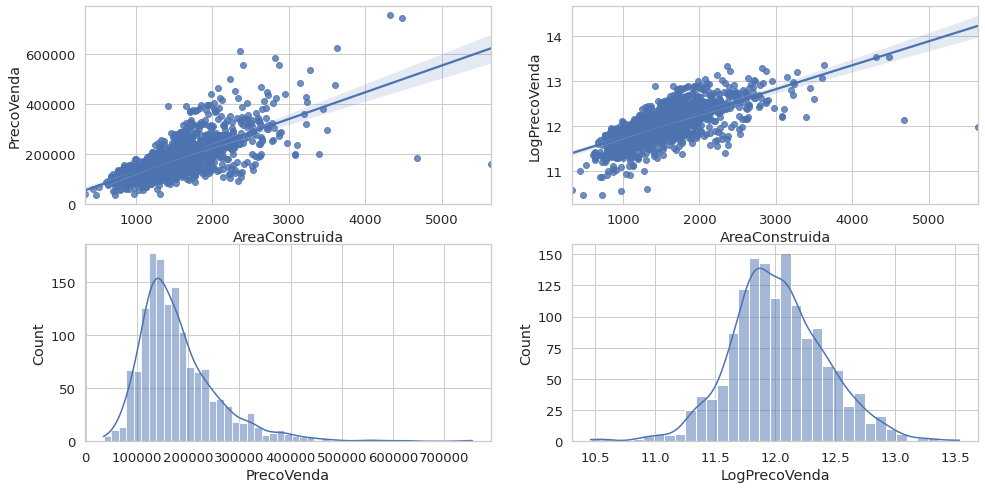

In [ ]:
fig, axs = plt.subplots(figsize=(16,8), ncols=2, nrows=2)

sns.histplot(x=df.PrecoVenda, kde=True, ax=axs[1][0])
sns.histplot(x=df.LogPrecoVenda, kde=True, ax=axs[1][1])

sns.regplot(x='AreaConstruida', y='PrecoVenda', data=df, ax=axs[0][0])
sns.regplot(x='AreaConstruida', y='LogPrecoVenda', data=df, ax=axs[0][1])

plt.show()

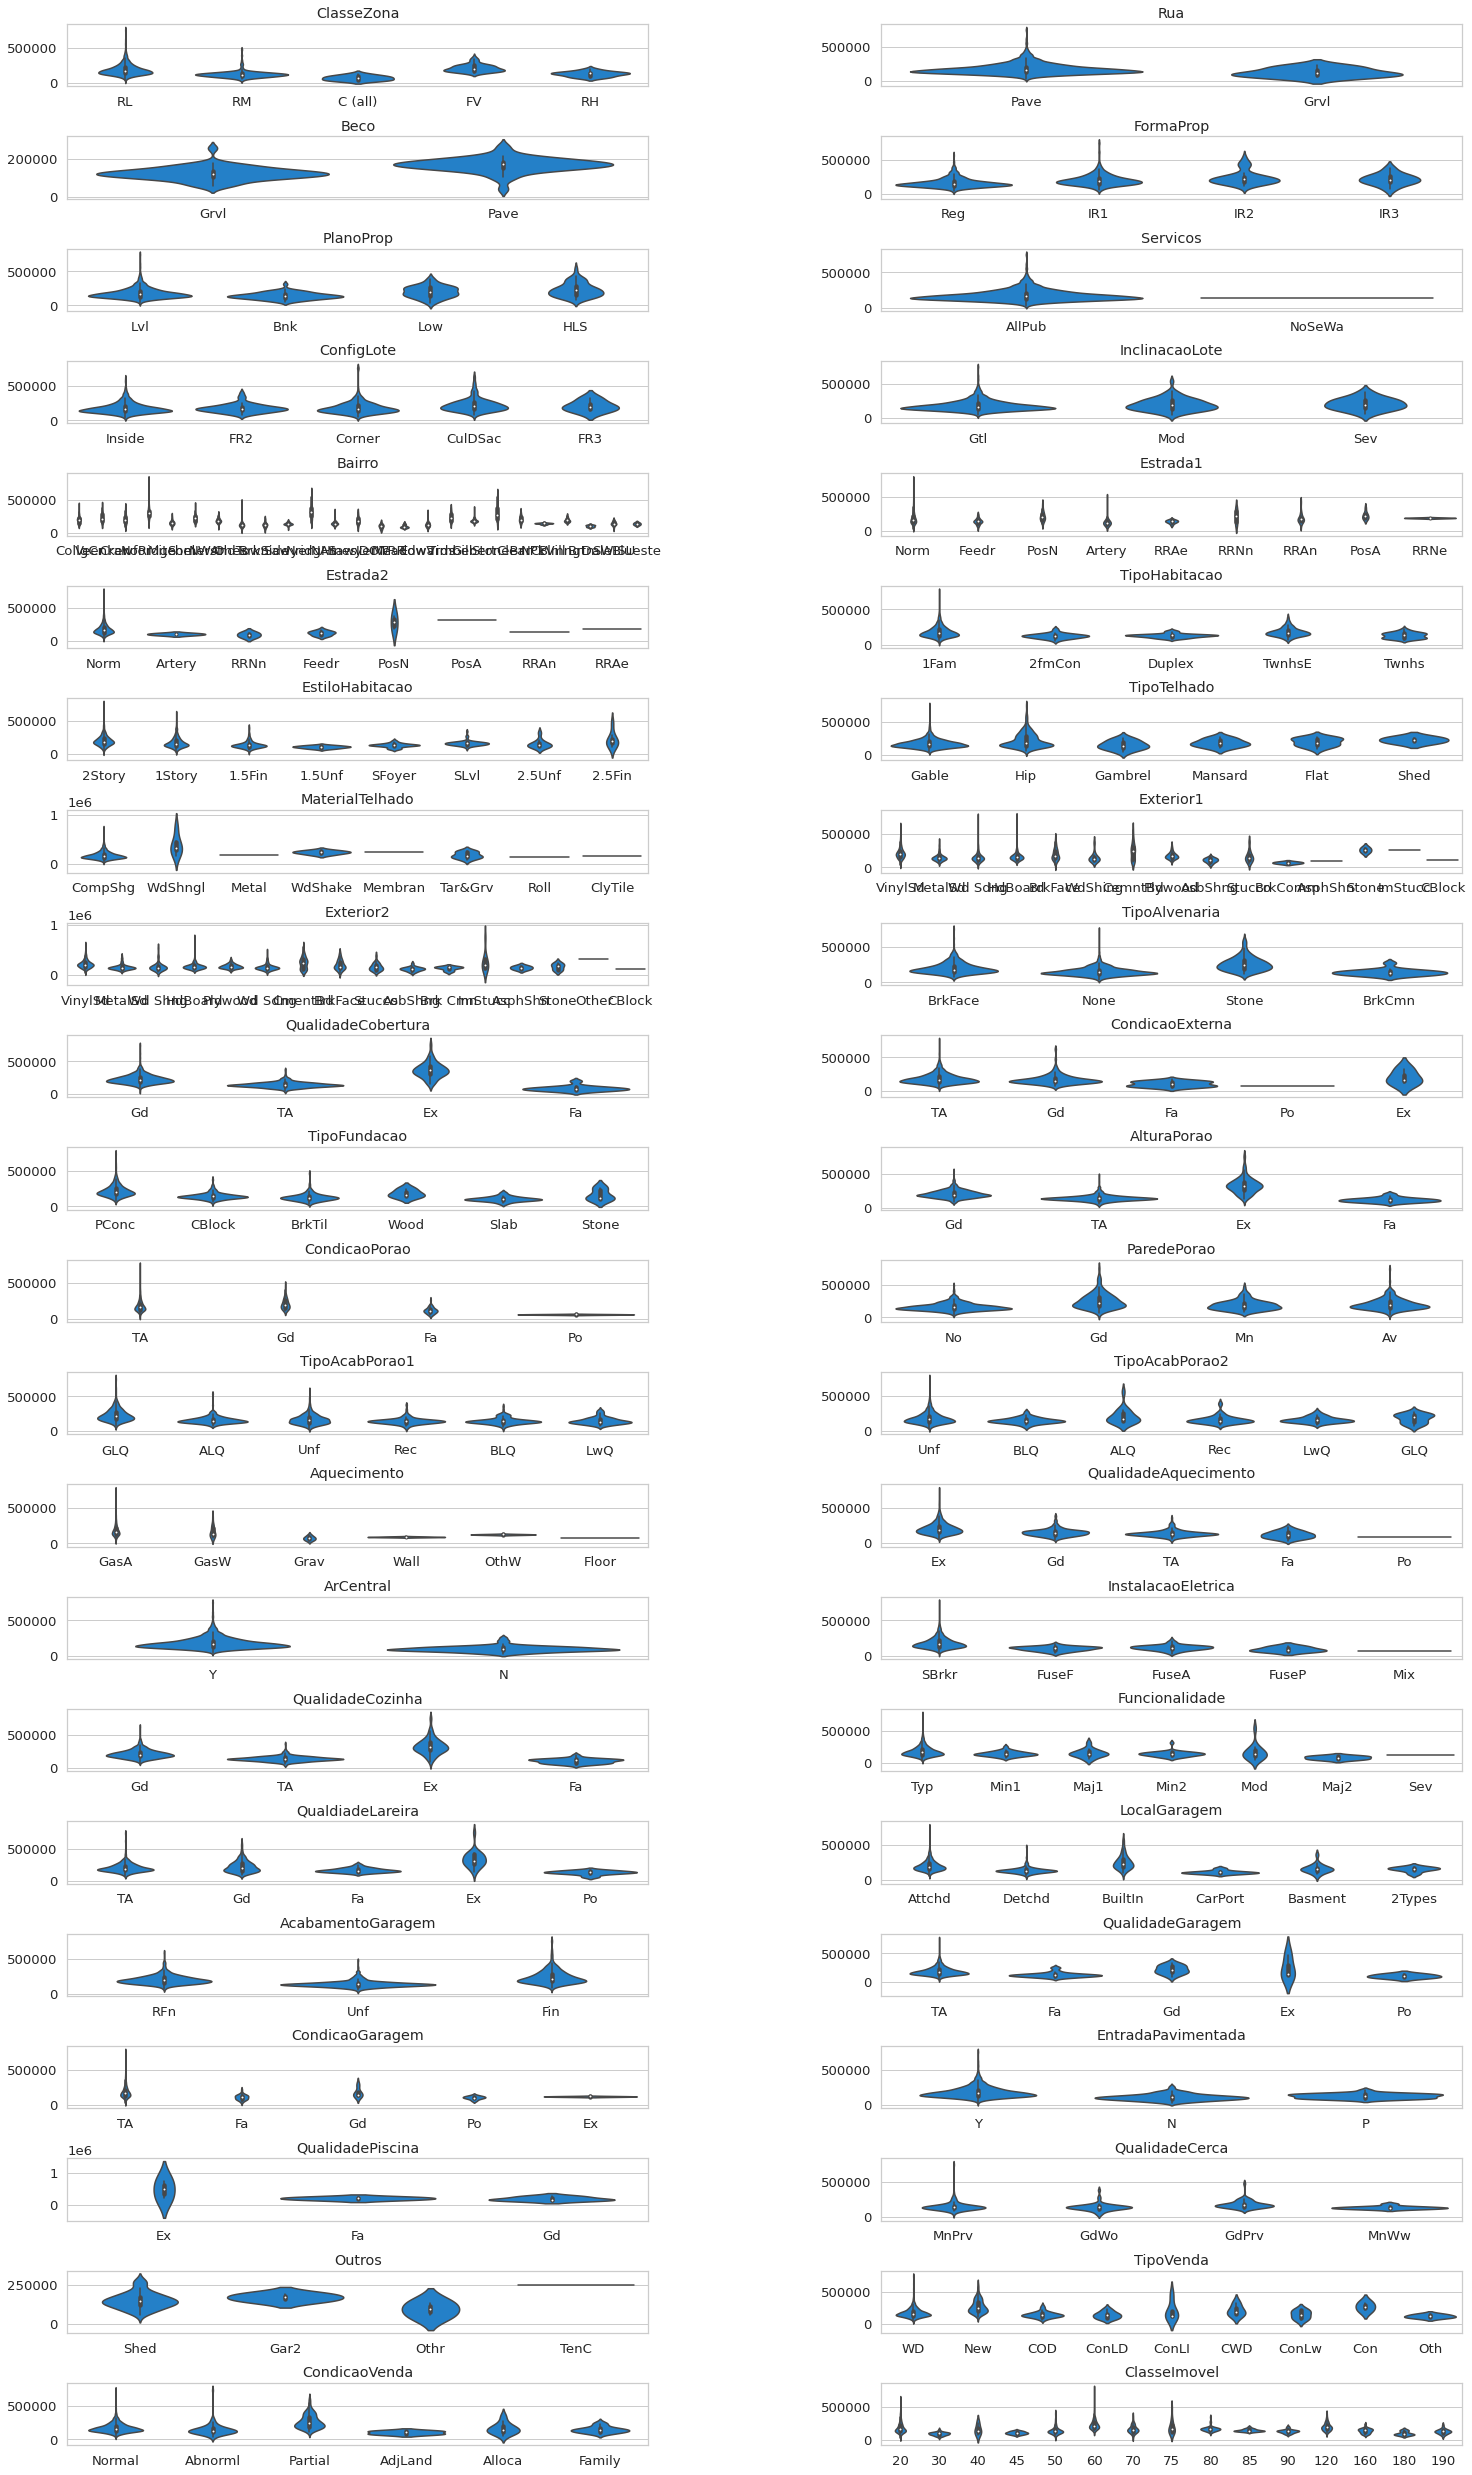

In [ ]:
# Configurando a figura do matplot lib
fig = plt.figure(figsize=(25,90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

total_plots = len(cat_vars)
i = 0
# Iterando para todas variaveis categoricas
for var in cat_vars:
    # Pegando o index certo para plotar o grafico
    ax = fig.add_subplot(total_plots, 2, i+1)
    # Desenhando o grafico do tipo violinplot
    sns.violinplot(x=var, y=target, color='#0984e3', title=var,data=df, ax=ax)
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

plt.show()

Verificando a cardinalidade das variáveis categóricas

In [ ]:
print('Cardinalidade médias das categóricas:', np.mean(df[cat_vars].nunique()))
df[cat_vars].nunique().sort_values(ascending=False)

Cardinalidade médias das categóricas: 6.068181818181818


Bairro                  25
Exterior2               16
ClasseImovel            15
Exterior1               15
TipoVenda                9
Estrada1                 9
Estrada2                 8
EstiloHabitacao          8
MaterialTelhado          8
Funcionalidade           7
TipoAcabPorao2           6
Aquecimento              6
TipoFundacao             6
LocalGaragem             6
CondicaoVenda            6
TipoTelhado              6
TipoAcabPorao1           6
CondicaoExterna          5
TipoHabitacao            5
ConfigLote               5
ClasseZona               5
CondicaoGaragem          5
QualidadeGaragem         5
QualidadeAquecimento     5
InstalacaoEletrica       5
QualdiadeLareira         5
FormaProp                4
PlanoProp                4
Outros                   4
QualidadeCerca           4
ParedePorao              4
CondicaoPorao            4
QualidadeCozinha         4
TipoAlvenaria            4
QualidadeCobertura       4
AlturaPorao              4
AcabamentoGaragem        3
E

Verificando a correlação entre as variáveis númericas

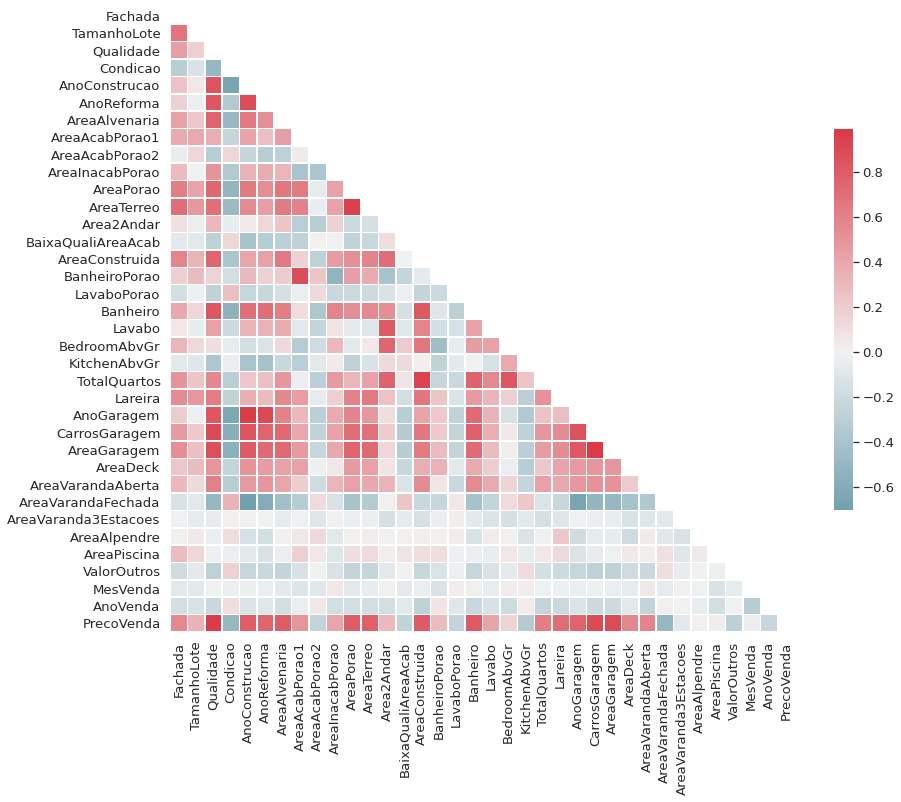

In [ ]:
corr_matrix = df[num_vars + [target]].corr()
plot_corr_matrix(corr_matrix)

Correlação das variáveis númericas com a variável de interesse (PrecoVenda)

In [ ]:
corr_matrix[target].sort_values(ascending=False)

PrecoVenda              1.000000
Qualidade               0.790982
AreaConstruida          0.708624
CarrosGaragem           0.640409
AreaGaragem             0.623431
AreaPorao               0.613581
AreaTerreo              0.605852
Banheiro                0.560664
TotalQuartos            0.533723
AnoConstrucao           0.522897
AnoReforma              0.507101
AnoGaragem              0.486362
AreaAlvenaria           0.477493
Lareira                 0.466929
AreaAcabPorao1          0.386420
Fachada                 0.351799
AreaDeck                0.324413
Area2Andar              0.319334
AreaVarandaAberta       0.315856
Lavabo                  0.284108
TamanhoLote             0.263843
BanheiroPorao           0.227122
AreaInacabPorao         0.214479
BedroomAbvGr            0.168213
AreaAlpendre            0.111447
AreaPiscina             0.092404
MesVenda                0.046432
AreaVaranda3Estacoes    0.044584
AreaAcabPorao2         -0.011378
LavaboPorao            -0.016844
ValorOutro

# Pré-Preprocessamento, limpeza dos dados, construção de features

Removendo algumas colunas com muitos dados faltantes, ou que não fazem sentido para a resolução do problema

In [ ]:
nans = df.isna().sum()
nans = nans[nans > 0]/len(df)
nans[nans > 0.95]

QualidadePiscina    0.995205
Outros              0.963014
dtype: float64

In [ ]:
cols_to_remove = ['QualidadePiscina', 'Outros', 'AnoVenda']

Criando novas features (feature engineering)

In [ ]:
# Selecionando apenas as features de area
area_features = [var for var in num_vars if 'area' in var.lower()]

# Eleveando ao quadrado as features de area
df_area_squared = df[area_features].pow(2)
df_area_squared.columns = [var + '_squared' for var in area_features]
df_processed = pd.concat([df, df_area_squared], axis=1)
print('New are squared features: ', list(df_area_squared.columns))

# Dividino o total de alguns itens pela area construida
itens = ['Banheiro', 'Lavabo', 'TotalQuartos', 'Lareira', 'CarrosGaragem']
df_itens_over_area = df_processed[itens].div(df_processed.AreaConstruida, axis=0)
df_itens_over_area.columns = [var + '_sobreArea' for var in itens]
df_processed = pd.concat([df_processed, df_itens_over_area], axis=1)
print('New itens over area features: ', list(df_itens_over_area.columns))

# Removendo colunas com muitos missings
df_processed.drop(cols_to_remove, axis=1, inplace=True)

# Shape do novo dataset processado
print('Shape old df: ', df.shape)
print('Shape new df: ', df_processed.shape)

New are squared features:  ['AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared']
New are squared features:  ['Banheiro_sobreArea', 'Lavabo_sobreArea', 'TotalQuartos_sobreArea', 'Lareira_sobreArea', 'CarrosGaragem_sobreArea']
Shape old df:  (1460, 81)
Shape new df:  (1460, 99)


selecionando novamente as variáveis númericas e categóricas no dataset processado

In [ ]:
# Features numericas
num_features = df_processed.select_dtypes(include=['int', 'float']).columns.tolist()
num_features.remove('ClasseImovel')
num_features.remove('LogPrecoVenda')
num_features.remove('PrecoVenda')
print(f'numerical features({len(num_features)}): {num_features}')

# Features categoricas
cat_features = df_processed.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_features.append('ClasseImovel')
df_processed[cat_features] = df_processed[cat_features].astype("category")
print(f'categorical features({len(cat_features)}): {cat_features}')

# features_to_remove = ['AnoVenda', 'LogPrecoVenda', 'PrecoVenda']

numerical features(55): ['Fachada', 'TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared', 'Banheiro_sobreArea', 'Lavabo_sobreAre

# 1. Objetivo I - Regressão Linear para interpretabilidade

Utilizando apenas exemplos onde a variável Condicao é igual à *Normal*

In [ ]:
df_lr = df_processed[df_processed.CondicaoVenda == 'Normal'].copy()
df_lr = pd.get_dummies(df_lr, columns=['ArCentral'], drop_first=True)

# Valores da var QualidadeCozinha:
# Ex Excelente
# Gd Bom
# TA Médio / Comum
# Fa Razoável
# Po Ruim

df_lr['QualidadeCozinha'] = df_lr['QualidadeCozinha'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
len(df_lr)

1198

Usando o VIF (Variance Inflation Factor) para verificar a colinearidade de certos conjutos de variáveis

In [ ]:
lr_vars = ['AreaConstruida', 'CarrosGaragem', 'ArCentral_Y', 'AreaPorao', 'Banheiro', 'QualidadeCozinha'] # R2 0.824
plot_vif(calc_vif(df_lr[lr_vars]))

lr_vars = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"] # R2 0.852
plot_vif(calc_vif(df_lr[lr_vars]))

vars:  ['variables', 'VIF']
Variable Inflation Factors: 90.16591366626699 

vars:  ['variables', 'VIF']
Variable Inflation Factors: 108.14489255540519 



Fitando a regressão linear

In [ ]:

# Montando a formula da regressao linear
lr_vars = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"] # R2 0.852
formula ="LogPrecoVenda ~ " + ' + '.join(lr_vars)
print('formula: ', formula)

# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df_lr).fit()

# Plotando o sumario do modelo
print(model.summary())

formula:  LogPrecoVenda ~ AreaConstruida + Qualidade + CarrosGaragem + AreaPorao + Banheiro + ArCentral_Y
                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1139.
Date:                Sat, 05 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:11:50   Log-Likelihood:                 644.77
No. Observations:                1198   AIC:                            -1276.
Df Residuals:                    1191   BIC:                            -1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

Verificando o VIF das variáveis escolhidas para compor a regressão linear

In [ ]:
vif = calc_vif(df_lr[lr_vars])
print('vars: ', lr_vars)
print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
vif

vars:  ['AreaConstruida', 'Qualidade', 'CarrosGaragem', 'AreaPorao', 'Banheiro', 'ArCentral_Y']
Variable Inflation Factors: 108.14489255540519 



,variables,VIF
0,AreaConstruida,20.561712
1,Qualidade,36.544938
2,CarrosGaragem,11.040106
3,AreaPorao,10.491630
4,Banheiro,17.210607
5,ArCentral_Y,12.295900


Correlação das variáveis da regressão linear

,AreaConstruida,Qualidade,CarrosGaragem,AreaPorao,Banheiro,ArCentral_Y
AreaConstruida,1.000000,0.576861,0.465061,0.383522,0.650396,0.076536
Qualidade,0.576861,1.000000,0.564465,0.494476,0.525825,0.255123
CarrosGaragem,0.465061,0.564465,1.000000,0.409797,0.452606,0.211898
AreaPorao,0.383522,0.494476,0.409797,1.000000,0.304859,0.202598
Banheiro,0.650396,0.525825,0.452606,0.304859,1.000000,0.074507
ArCentral_Y,0.076536,0.255123,0.211898,0.202598,0.074507,1.000000


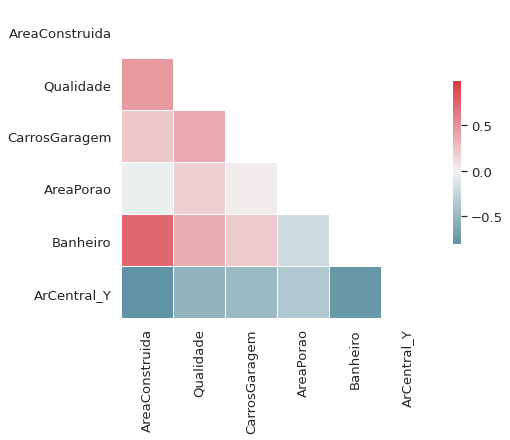

In [ ]:
corr_matrix = df_lr[lr_vars].corr()
plot_corr_matrix(df_lr[lr_vars].corr(), (7, 6))
corr_matrix

Checando a Heteroscedasticidade (aumento do erro conforme aumenta a área do imóvel)

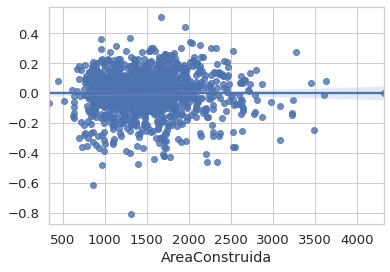

In [ ]:
sns.regplot(x=df_lr.AreaConstruida , y=model.resid)

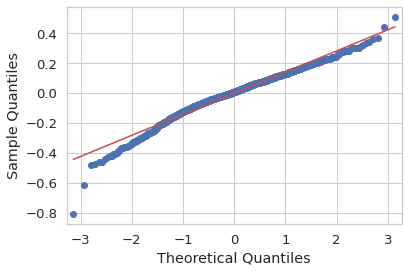

In [ ]:
sm.qqplot(model.resid, line="s");

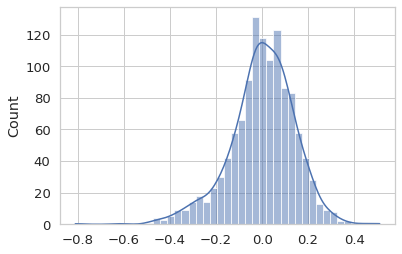

In [ ]:
sns.histplot(model.resid, kde=True)

In [ ]:
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.02
Qualidade         10.58
CarrosGaragem      9.41
AreaPorao          0.02
Banheiro           1.56
ArCentral_Y       24.58
dtype: float64

Interpretação dos coeficientes:
* AreaConstruida     0.02% (Aumento de 1 unidade da AreaConstruida aumenta em 0.02% o preço do imóvel)
* Qualidade         10.58% (Para cada aumento do nível de qualidade, indo de 1-muito ruim até 10-Muito excelente, aumenta em 10.58% o preço do imóvel)
* CarrosGaragem      9.41% (Aumento de 1 unidade de CarrosGaragem aumenta em 9.41% o preço do imóvel)
* AreaPorao          0.02% (Aumento de 1 unidade da AreaPorao aumenta em 0.02% o preço do imóvel)
* Banheiro           1.56% (Aumento de 1 unidade de Banheiros aumenta em 1.56% o preço do imóvel)
* ArCentral_Y       24.58% (Presença de ar condicionado central aumenta 24.58% o valor do imóvel)

# 2. Objetivo II: poder preditivo, regressão via random forest

Splitando os dados em treino e teste

In [ ]:
features = num_features + cat_features
# TO-DO rever essa parte
# features = [feature for feature in features if feature not in features_to_remove]

(
  X_train, X_test, 
  X_val, y_train, 
  y_test, y_val
) = train_test_valid_split(df_processed, features=features, target=target, test_size=0.3, valid_size=0.5, random_state=42)

print('X Train shape', X_train.shape)
print('X Val shape', X_val.shape)
print('X Test shape', X_test.shape)

X Train shape (1022, 97)
X Val shape (219, 97)
X Test shape (219, 97)


Pre-processamento dos datasets de treino, teste e validação

In [ ]:
def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Categoricals pre-processing (categorical encoders)
  target_encoder = TargetEncoder()
  X_train[cat_features] = target_encoder.fit_transform(X_train[cat_features], y_train)
  X_val[cat_features] = target_encoder.transform(X_val[cat_features])
  X_test[cat_features] = target_encoder.transform(X_test[cat_features])

  # Numerical pre-processing (missing imputer)
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
  X_val[num_features] = num_imputer.transform(X_val[num_features])
  X_test[num_features] = num_imputer.transform(X_test[num_features])

  return X_train, X_val, X_test

X_train, X_val, X_test = random_forest_preprocessing(X_train.copy(), X_val.copy(), X_test.copy(), y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Fitando um RandomForest baseline

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validation')
baseline_report

,metric,validation
0,RMSE,28825.24
1,MAE,16692.37
2,R^2,0.89
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,171523.33


## Achando os melhores hiperparâmetros para o RandomForest

In [ ]:
# hiperparams: n_estimators: [], max_features: [], min_samples_leaf: []
for n_estimators in [10, 30, 50, 70, 100, 150, 200]:
  print(f'Random forest, with n_estimators {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with n_estimators 10
rmse: 29858.23778006674

Random forest, with n_estimators 30
rmse: 29459.714524146897

Random forest, with n_estimators 50
rmse: 29385.697272338886

Random forest, with n_estimators 70
rmse: 28673.06345705987

Random forest, with n_estimators 100
rmse: 28825.23841553389

Random forest, with n_estimators 150
rmse: 28469.57628297523

Random forest, with n_estimators 200
rmse: 28731.072647207577



In [ ]:
# hiperparams: n_estimators: [150], max_features: [], min_samples_leaf: []
for max_features in ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.6]:
  print(f'Random forest, with max_features {max_features}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=max_features, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with max_features sqrt
rmse: 29888.132345497015

Random forest, with max_features 0.1
rmse: 29888.132345497015

Random forest, with max_features 0.2
rmse: 28744.299535101163

Random forest, with max_features 0.3
rmse: 27241.38692216558

Random forest, with max_features 0.4
rmse: 27904.796803895464

Random forest, with max_features 0.6
rmse: 27722.18162942812



In [ ]:
# hiperparams: n_estimators: [100], max_features: [0.3], min_samples_leaf: []
for min_samples_leaf in list(range(1,6)):
  print(f'Random forest, with min_samples_leaf {min_samples_leaf}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= min_samples_leaf, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with min_samples_leaf 1
rmse: 27241.38692216558

Random forest, with min_samples_leaf 2
rmse: 28106.10814576189

Random forest, with min_samples_leaf 3
rmse: 29461.733689872966

Random forest, with min_samples_leaf 4
rmse: 30432.507172291633

Random forest, with min_samples_leaf 5
rmse: 31222.58036385704



## Random Forest com os melhores hiperparâmetros

In [ ]:
# hiperparams: n_estimators: [100], max_features: [0.3], min_samples_leaf: [1]
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred = rf_model.predict(X_val)
metrics_report(y_val, y_val_pred, 'validation')

,metric,validation
0,RMSE,27241.39
1,MAE,16155.45
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,172298.50


## Importância das features, removendo variáveis pouco importantes

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
print('Running permutation feature importance')
permutation_result = permutation_importance(rf_model, X_val, y_val, n_repeats=5, random_state=42)

Running permutation feature importance


plotando o permutation feature importance

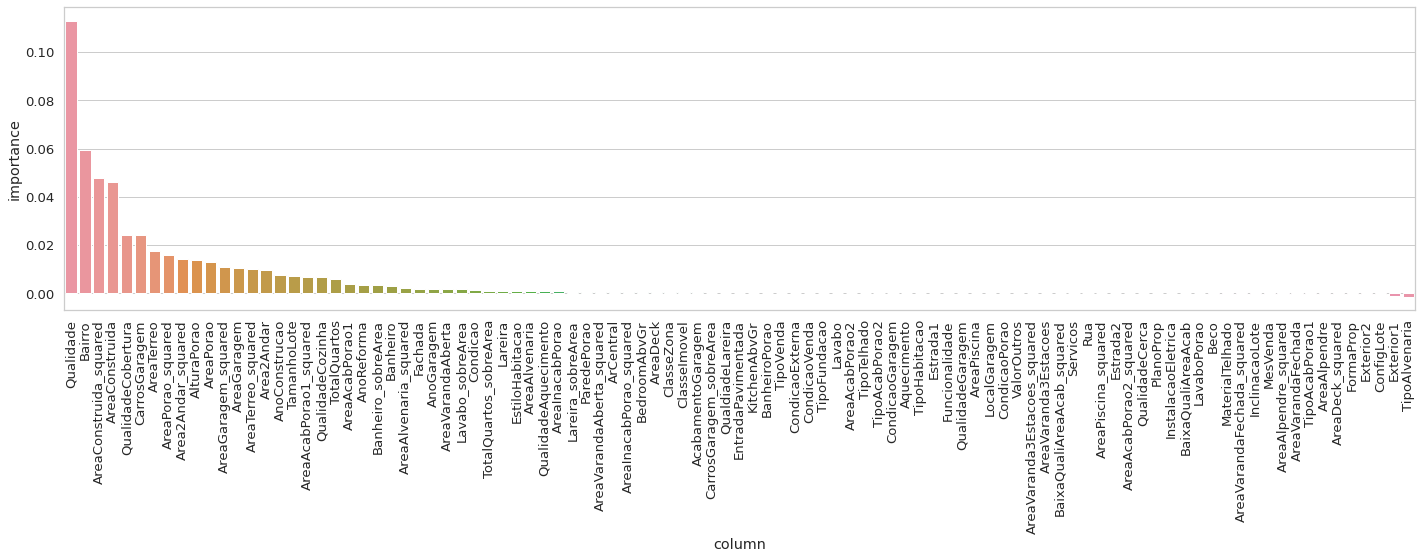

In [ ]:
importances = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# Getting the top 40 best features
best_features = importances.head(25).column.tolist()
print(best_features)

['Qualidade', 'Bairro', 'AreaConstruida_squared', 'AreaConstruida', 'QualidadeCobertura', 'CarrosGaragem', 'AreaTerreo', 'AreaPorao_squared', 'Area2Andar_squared', 'AlturaPorao', 'AreaPorao', 'AreaGaragem_squared', 'AreaGaragem', 'AreaTerreo_squared', 'Area2Andar', 'AnoConstrucao', 'TamanhoLote', 'AreaAcabPorao1_squared', 'QualidadeCozinha', 'TotalQuartos', 'AreaAcabPorao1', 'AnoReforma', 'Banheiro_sobreArea', 'Banheiro', 'AreaAlvenaria_squared']


## Retreinando o RandomForest apenas com as top 25 variáveis mais importantes

In [ ]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_val[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
val_report = metrics_report(y_val, y_val_pred, 'validation')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report, val_report[['validation']],  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(features)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 97)
            metric  validation
0             RMSE    28825.24
1              MAE    16692.37
2              R^2        0.89
3             MAPE        0.09
4      Avg. target   174313.75
5  Avg. Prediction   171523.33

Baseline report (total features: 25)
            metric      train  validation       test
0             RMSE   11519.61    25911.79   22917.56
1              MAE    6606.16    15973.66   15170.13
2              R^2       0.98        0.91       0.92
3             MAPE       0.04        0.09       0.10
4      Avg. target  181312.69   174313.75  185701.65
5  Avg. Prediction  181068.50   171884.16  185494.16


Computanto a importancia das features do modelo final no dataset de test (held-out testing set)

Running permutation feature importance with the final model on the held-out testing set


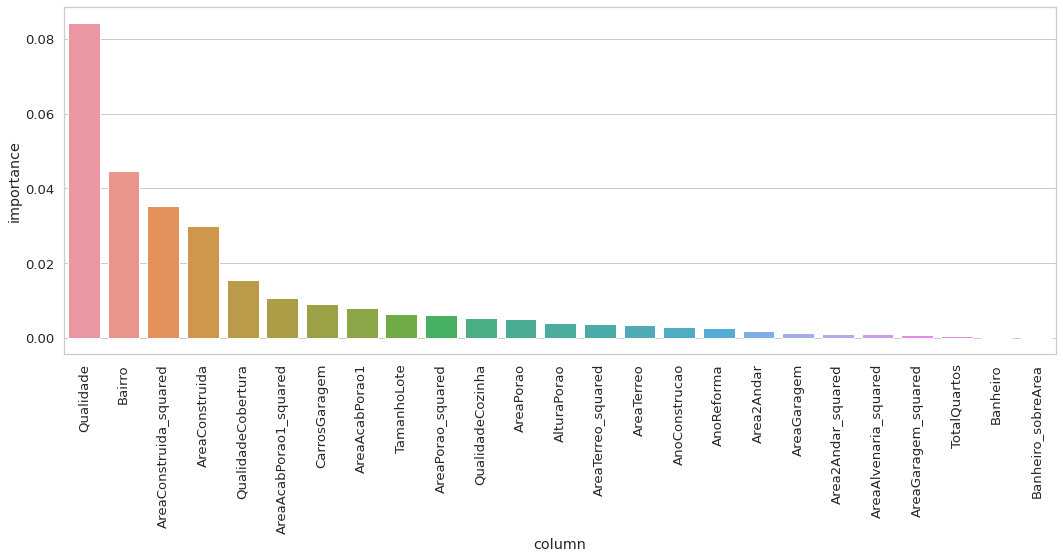

In [ ]:
print('Running permutation feature importance with the final model on the held-out testing set')
permutation_result = permutation_importance(rf_model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()